In [1]:
!pip install tensorflow pydot

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf

warnings.filterwarnings("ignore")

In [3]:
path = r"465 dataset/Axial"

data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 10000)

Found 5154 files belonging to 3 classes.


In [4]:
class_names = data.class_names
print(class_names)

['AD', 'CI', 'CN']


In [5]:
label_map = {m : n for m, n in zip(np.arange(len(class_names)), class_names)}
print(label_map)

{0: 'AD', 1: 'CI', 2: 'CN'}


In [6]:
for images, labels in data:
    X = images.numpy().astype("uint8")
    y = labels.numpy().astype("uint8")

print(X.shape, y.shape)

(5154, 128, 128, 3) (5154,)


In [7]:
X_gray = np.zeros(shape = (*X.shape[:-1], 1))

for idx, img in enumerate(X):
    X_gray[idx] = tf.image.rgb_to_grayscale(img)

X = X_gray.copy()
print(X_gray.shape)

(5154, 128, 128, 1)


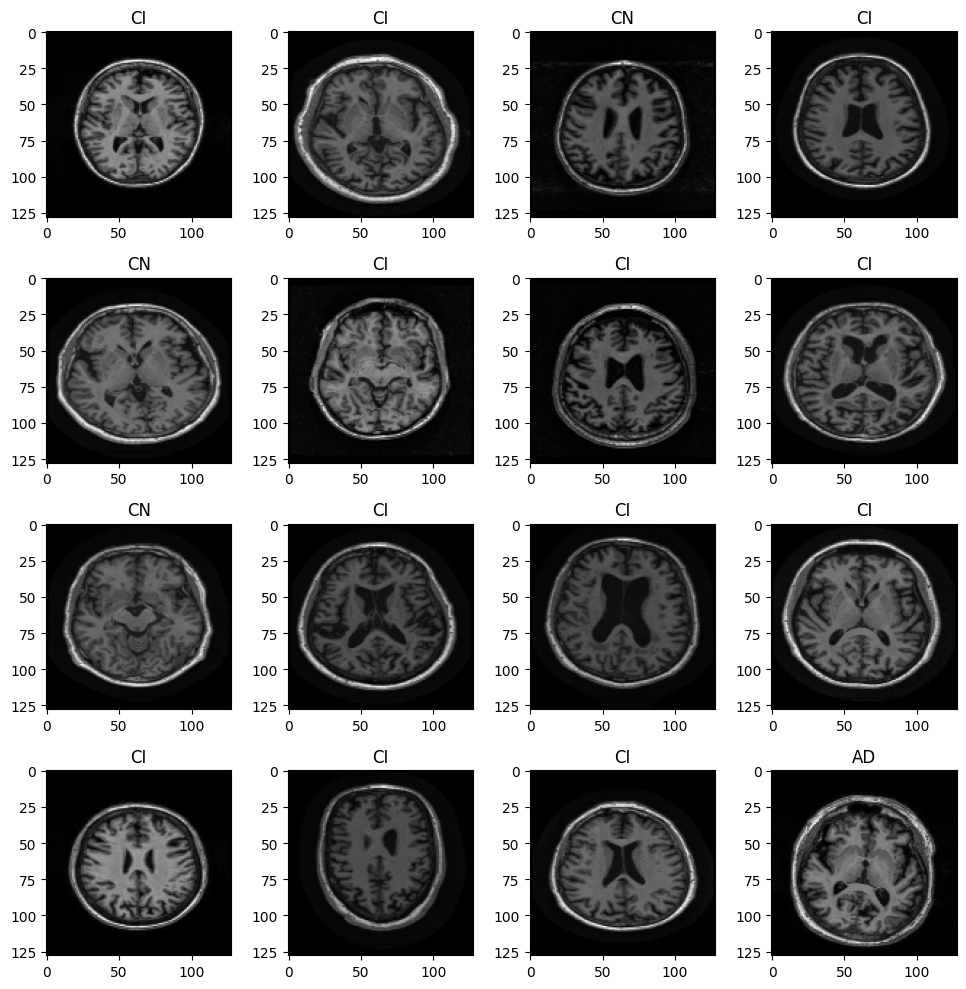

In [8]:
plt.figure(figsize = (10, 10))

for i in range(16):
    img = X[i]
    plt.subplot(4, 4, i + 1)
    plt.title(label_map[y[i]])
    plt.gray()
    plt.imshow(img)
    plt.tight_layout()
plt.show()

CI


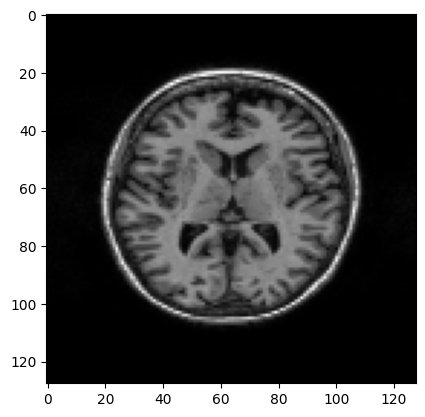

CN


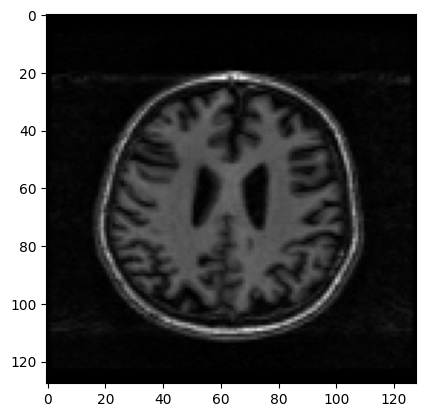

AD


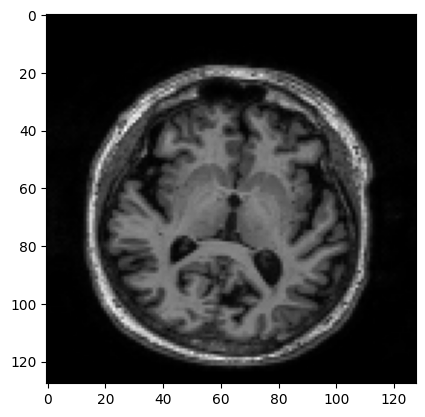

In [9]:
visited = set()

for img, label in zip(X_gray, y):
    if len(visited) == 3:
        break
    if label in visited:
        continue
    visited.add(label)
    print(label_map[label])
    plt.gray()
    plt.imshow(img)
    plt.show()

In [10]:
label_counts = pd.Series(y).value_counts()
print(label_counts)

1    2590
2    1440
0    1124
Name: count, dtype: int64


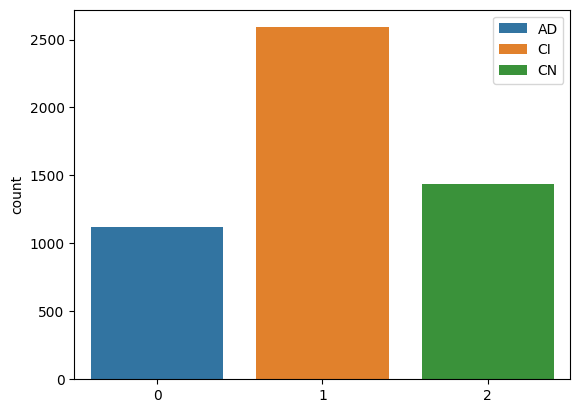

In [11]:
sns.countplot(x = y, label = label_map.values())
plt.legend()
plt.show()

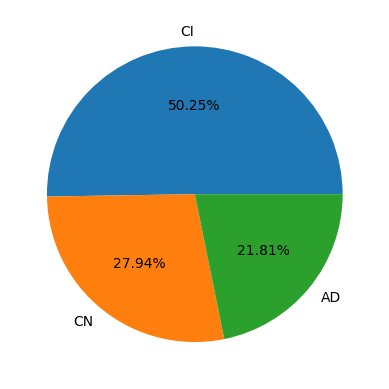

In [12]:
plt.pie(label_counts, autopct = "%.2f%%", labels = list(map(lambda key : label_map[key], label_counts.keys())))
plt.show()

In [13]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Create a data generator with augmentation
# data_gen = ImageDataGenerator(
#     rotation_range=20,  # Rotate images up to 20 degrees
#     width_shift_range=0.1,  # Shift images horizontally by 10%
#     height_shift_range=0.1,  # Shift images vertically by 10%
#     shear_range=0.1,  # Shearing
#     zoom_range=0.1,  # Zoom in/out by 10%
#     horizontal_flip=True,  # Flip images horizontally
#     fill_mode='nearest'  # Filling strategy for augmented pixels
# )

# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip(mode = "horizontal_and_vertical"),
# ])

In [14]:
# X_new, y_new = [], []
# max_total = 3000
# X_0, X_1, X_2 = X[y == 0], X[y == 1], X[y == 2]

# for label, X_set in zip(label_map.keys(), [X_0, X_1, X_2]):
#     count = 0
#     for img in X_set:
#         if count > max_total - label_counts[label]:
#             break
#         for i in range(2):
#             augmented_img = data_augmentation(img)
#             X_new.append(augmented_img)
#             y_new.append(label)
#             count += 1

# X_new, y_new = np.array(X_new), np.array(y_new)
# print(X_new.shape, y_new.shape)

import tensorflow as tf
import numpy as np

# Define the improved data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),              # Horizontal flip
    tf.keras.layers.RandomRotation(0.05),                  # Small rotation (5%)
    tf.keras.layers.RandomTranslation(0.05, 0.05),         # Small shift (5%)
    tf.keras.layers.RandomContrast(0.15),                  # Slight contrast variation (15%)
    tf.keras.layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=0.01)),  # Add Gaussian noise
])

# Initialize lists for new augmented data
X_new, y_new = [], []
max_total = 3000
X_0, X_1, X_2 = X[y == 0], X[y == 1], X[y == 2]

# Generate augmented data per class to balance
for label, X_set in zip(label_map.keys(), [X_0, X_1, X_2]):
    count = 0
    for img in X_set:
        if count >= max_total - label_counts[label]:
            break
        for _ in range(3):  # Generate three augmentations per image
            augmented_img = data_augmentation(img[None, ...])  # Add batch dimension
            X_new.append(tf.squeeze(augmented_img).numpy())    # Squeeze and convert to numpy
            y_new.append(label)
            count += 1

# Convert lists to arrays and ensure dimensions match
X_new, y_new = np.array(X_new), np.array(y_new)

# Ensure `X` and `X_new` have the same number of dimensions
if X.ndim == 3:  # If X is [num_samples, height, width]
    X = np.expand_dims(X, axis=-1)  # Convert to [num_samples, height, width, channels]
if X_new.ndim == 3:
    X_new = np.expand_dims(X_new, axis=-1)

# Concatenate original and augmented datasets
X = np.concatenate([X, X_new], axis=0)
y = np.concatenate([y, y_new], axis=0)

print("Final augmented dataset shape:", X.shape, y.shape)



Final augmented dataset shape: (9003, 128, 128, 1) (9003,)


In [15]:
# X = np.concatenate([X, X_new])
# y = np.concatenate([y, y_new])

# print(X.shape, y.shape)

In [16]:
print(pd.Series(y).value_counts())

0    3002
1    3001
2    3000
Name: count, dtype: int64


In [17]:
# Min-Max Normalization

X = X / 255.0

print(X.min(), X.max())

-0.0002213799632063099 1.0000987931793812


In [18]:
# Splitting the data into training, testing and validation sets

X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, y, test_size = 0.15,
                                                                            random_state = 3, stratify = y)

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size = 0.15,
                                                                  random_state = 3, stratify = y_train_val)

print(X_train.shape, X_val.shape, X_test.shape)

print(f"Total instances: {X.shape[0]}\nTrain instances: {X_train.shape[0]}   \
        \nValidation instances: {X_val.shape[0]}\nTest instances: {X_test.shape[0]}")

(6504, 128, 128, 1) (1148, 128, 128, 1) (1351, 128, 128, 1)
Total instances: 9003
Train instances: 6504           
Validation instances: 1148
Test instances: 1351


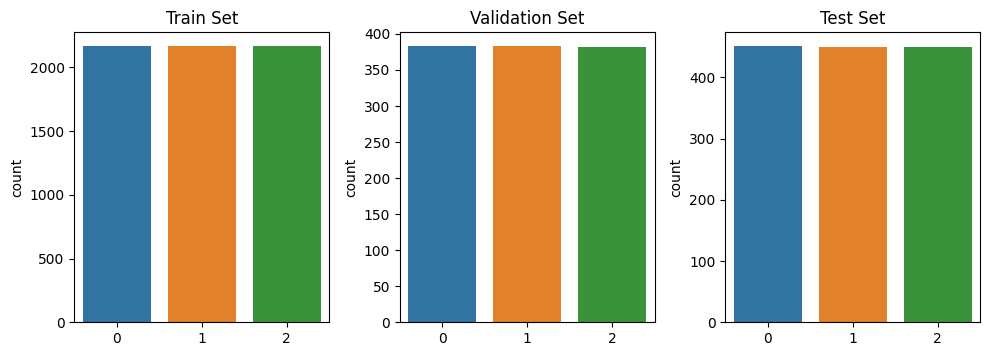

In [19]:
# Checking whether the classes are distributed uniformely among train, test and validation sets

plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    sns.countplot(x = labels)
    plt.tight_layout()
plt.show()

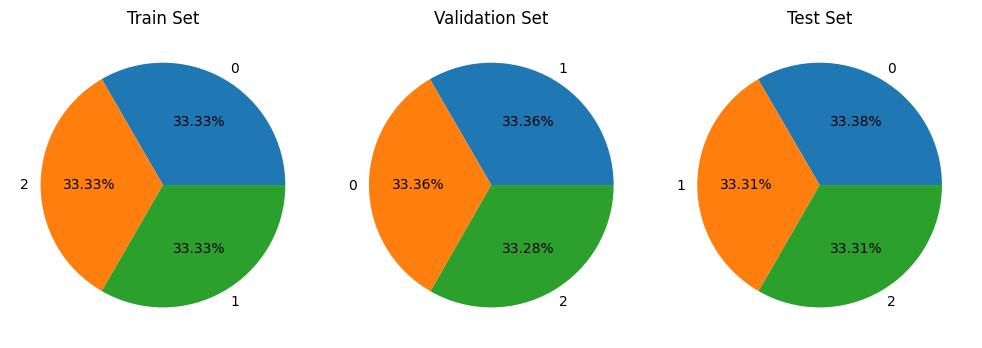

In [20]:
plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    label_counts = pd.Series(labels).value_counts()
    plt.pie(label_counts, autopct = "%.2f%%", labels = label_counts.keys())
    plt.tight_layout()
plt.show()

In [21]:
# # Model building

# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(filters = 200, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
#     tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
#     tf.keras.layers.Conv2D(filters = 100, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
#     tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units = 100, activation = "relu"),
#     tf.keras.layers.Dense(units = 50, activation = "relu"),
#     tf.keras.layers.Dense(units = 3, activation = "softmax")
# ])

from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Example of adding Dropout after dense layers
model = tf.keras.models.Sequential([
    # Example CNN layers with explicit names
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1:]), name="teacher_conv2d_1"),
    tf.keras.layers.MaxPooling2D((2, 2), name="teacher_maxpool_1"),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name="teacher_conv2d_2"),
    tf.keras.layers.MaxPooling2D((2, 2), name="teacher_maxpool_2"),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', name="teacher_conv2d_3"),
    tf.keras.layers.MaxPooling2D((2, 2), name="teacher_maxpool_3"),

    tf.keras.layers.Flatten(name="teacher_flatten"),

    # Adding L2 regularization to the Dense layer
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001), name="teacher_dense_1"),

    # Add dropout layer here with a 30% dropout rate
    tf.keras.layers.Dropout(0.3, name="teacher_dropout_1"),  # Adjust the dropout rate (0.3) as needed

    tf.keras.layers.Dense(128, activation='relu', name="teacher_dense_2"),

    # Another dropout layer
    tf.keras.layers.Dropout(0.3, name="teacher_dropout_2"),

    tf.keras.layers.Dense(units=3, activation='softmax', name="teacher_output")
])



In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ teacher_conv2d_1 (Conv2D)            │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ teacher_maxpool_1 (MaxPooling2D)     │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ teacher_conv2d_2 (Conv2D)            │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ teacher_maxpool_2 (MaxPooling2D)     │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ teacher_conv2d_3 (Conv2D)            │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ teacher_maxpool_3 (MaxPooling2D)     │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ teacher_flatten (Flatten)            │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ teacher_dense_1 (Dense)              │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ teacher_dropout_1 (Dropout)          │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ teacher_dense_2 (Dense)              │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ teacher_dropout_2 (Dropout)          │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ teacher_output (Dense)               │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,320,963 (12.67 MB)

 Trainable params: 3,320,963 (12.67 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
for idx, layer in enumerate(model.layers):
    print(f"Layer {idx}:", layer.name, layer.output.shape, layer.count_params())

Layer 0: teacher_conv2d_1 (None, 126, 126, 32) 320
Layer 1: teacher_maxpool_1 (None, 63, 63, 32) 0
Layer 2: teacher_conv2d_2 (None, 61, 61, 64) 18496
Layer 3: teacher_maxpool_2 (None, 30, 30, 64) 0
Layer 4: teacher_conv2d_3 (None, 28, 28, 128) 73856
Layer 5: teacher_maxpool_3 (None, 14, 14, 128) 0
Layer 6: teacher_flatten (None, 25088) 0
Layer 7: teacher_dense_1 (None, 128) 3211392
Layer 8: teacher_dropout_1 (None, 128) 0
Layer 9: teacher_dense_2 (None, 128) 16512
Layer 10: teacher_dropout_2 (None, 128) 0
Layer 11: teacher_output (None, 3) 387


In [24]:
model.compile(optimizer = "adam", loss = "SparseCategoricalCrossentropy", metrics = ["accuracy"])

In [25]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Create a data generator with augmentation
# data_gen = ImageDataGenerator(
#     rotation_range=20,  # Rotate images up to 20 degrees
#     width_shift_range=0.1,  # Shift images horizontally by 10%
#     height_shift_range=0.1,  # Shift images vertically by 10%
#     shear_range=0.1,  # Shearing
#     zoom_range=0.1,  # Zoom in/out by 10%
#     horizontal_flip=True,  # Flip images horizontally
#     fill_mode='nearest'  # Filling strategy for augmented pixels
# )

In [26]:
cb1 = tf.keras.callbacks.ModelCheckpoint("clf_model.keras", save_best_only=True)
cb2 = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
cb3 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.01)

history = model.fit(X_train, y_train, epochs=100, callbacks=[cb1, cb2, cb3], validation_data=(X_val, y_val))

# cb1 = tf.keras.callbacks.ModelCheckpoint("clf_model.keras", save_best_only=True)
# cb2 = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# cb3 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

# # Add the new callback to the list
# history = model.fit(
#     data_gen.flow(X_train, y_train, batch_size=32),
#     epochs=100,
#     validation_data=(X_val, y_val),
#     callbacks=[cb1, cb2, cb3]
# )

Epoch 1/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - accuracy: 0.3896 - loss: 1.1542 - val_accuracy: 0.5505 - val_loss: 0.9736 - learning_rate: 0.0010
Epoch 2/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 137ms/step - accuracy: 0.5861 - loss: 0.9254 - val_accuracy: 0.7343 - val_loss: 0.6905 - learning_rate: 0.0010
Epoch 3/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - accuracy: 0.7559 - loss: 0.6783 - val_accuracy: 0.8197 - val_loss: 0.5751 - learning_rate: 0.0010
Epoch 4/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 141ms/step - accuracy: 0.8313 - loss: 0.5456 - val_accuracy: 0.8885 - val_loss: 0.4377 - learning_rate: 0.0010
Epoch 5/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 145ms/step - accuracy: 0.8864 - loss: 0.4263 - val_accuracy: 0.9033 - val_loss: 0.3961 - learning_rate: 0.0010
Epoch 6/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - accuracy: 0.9065 - loss: 0.3847 - val_accuracy: 0.9094 - val_loss: 0.3982 - learning_rate: 0.0010
Epoch 7/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 136ms/step - accura

In [27]:
result_df = pd.DataFrame(history.history)
result_df.head()

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.430351,1.094230,0.550523,0.973574,0.001
1,0.623770,0.872402,0.734321,0.690515,0.001
2,0.773678,0.651525,0.819686,0.575094,0.001
3,0.846556,0.519957,0.888502,0.437743,0.001
4,0.881150,0.438695,0.903310,0.396142,0.001


In [28]:
result_df.describe()

,accuracy,loss,val_accuracy,val_loss,learning_rate
count,15.000000,15.000000,15.000000,15.000000,15.000
mean,0.862823,0.448664,0.866086,0.485017,0.001
std,0.149797,0.245049,0.100571,0.159499,0.000
min,0.430351,0.256505,0.550523,0.374317,0.001
25%,0.863853,0.298017,0.888066,0.402657,0.001
50%,0.924354,0.348381,0.903310,0.422664,0.001
75%,0.947801,0.479326,0.912021,0.490462,0.001
max,0.964022,1.094230,0.932056,0.973574,0.001


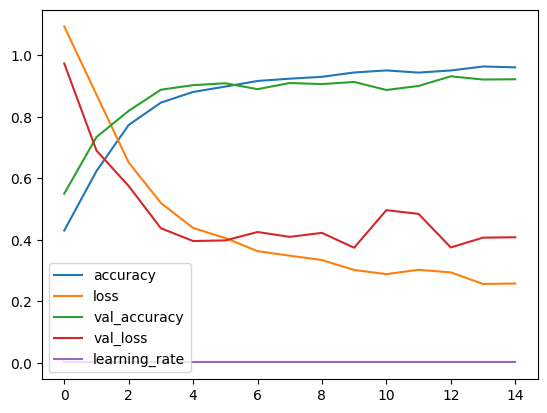

In [29]:
result_df.plot()
plt.show()


In [30]:
loss, acc = model.evaluate(X_train, y_train)

204/204 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9864 - loss: 0.2090


In [31]:
# Confusion Matrix

y_train_pred = model.predict(X_train)
y_train_pred_labels = np.array([np.argmax(y_) for y_ in y_train_pred])

cm = tf.math.confusion_matrix(labels = y_train, predictions = y_train_pred_labels)
print(cm)

204/204 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step
tf.Tensor(
[[2136    9   23]
 [  15 2127   26]
 [   9   11 2148]], shape=(3, 3), dtype=int32)


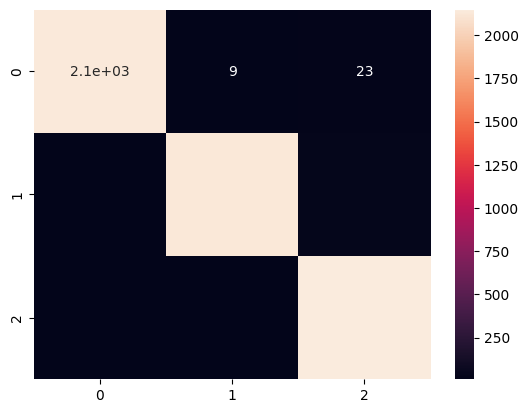

In [32]:
sns.heatmap(cm, annot = True)
plt.show()

In [33]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")

describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 2136
True Negatives : 4312
False Positives : 24
False Negatives : 32

Precision : 0.9888888888888889
Recall (Sensitivity) : 0.985239852398524
F1-Score : 0.9870609981515712


Class CI : 

True Positives : 2127
True Negatives : 4316
False Positives : 20
False Negatives : 41

Precision : 0.9906846762925011
Recall (Sensitivity) : 0.9810885608856088
F1-Score : 0.9858632676709155


Class CN : 

True Positives : 2148
True Negatives : 4287
False Positives : 49
False Negatives : 20

Precision : 0.9776968593536641
Recall (Sensitivity) : 0.9907749077490775
F1-Score : 0.9841924398625429


In [34]:
clf_report = metrics.classification_report(y_train, y_train_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2168
           1       0.99      0.98      0.99      2168
           2       0.98      0.99      0.98      2168

    accuracy                           0.99      6504
   macro avg       0.99      0.99      0.99      6504
weighted avg       0.99      0.99      0.99      6504



In [35]:
# Evaluating the model on test set

loss, acc = model.evaluate(X_test, y_test)

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9334 - loss: 0.3947


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


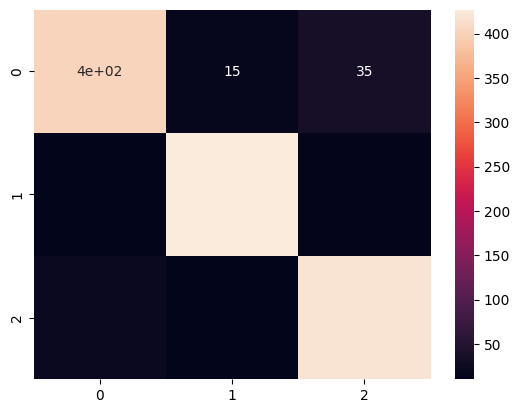

In [36]:
# Confusion Matrix

y_test_pred = model.predict(X_test)
y_test_pred_labels = np.array([np.argmax(y_) for y_ in y_test_pred])

cm = tf.math.confusion_matrix(labels = y_test, predictions = y_test_pred_labels)

sns.heatmap(cm, annot = True)
plt.show()

In [37]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")

describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 401
True Negatives : 868
False Positives : 32
False Negatives : 50

Precision : 0.9260969976905312
Recall (Sensitivity) : 0.8891352549889135
F1-Score : 0.9072398190045248


Class CI : 

True Positives : 427
True Negatives : 876
False Positives : 25
False Negatives : 23

Precision : 0.9446902654867256
Recall (Sensitivity) : 0.9488888888888889
F1-Score : 0.9467849223946785


Class CN : 

True Positives : 418
True Negatives : 853
False Positives : 48
False Negatives : 32

Precision : 0.8969957081545065
Recall (Sensitivity) : 0.9288888888888889
F1-Score : 0.9126637554585152


In [38]:
# Classification Report

clf_report = metrics.classification_report(y_test, y_test_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       451
           1       0.94      0.95      0.95       450
           2       0.90      0.93      0.91       450

    accuracy                           0.92      1351
   macro avg       0.92      0.92      0.92      1351
weighted avg       0.92      0.92      0.92      1351



In [39]:
model.save("clf_model_final.h5")

In [62]:
# Libraries
import os
import keras
from keras import layers
from keras import ops
import numpy as np
import tensorflow as tf
from tensorflow.keras.regularizers import l2

In [71]:
# def distillation_loss(teacher_logits, student_logits, temperature=3.0):
#     """
#     Computes the response-based distillation loss (soft targets).
#     Args:
#         teacher_logits: Logits from the teacher model
#         student_logits: Logits from the student model
#         temperature: Temperature for softening probability distributions
#     Returns:
#         Soft target loss
#     """
#     teacher_probs = ops.softmax(teacher_logits / temperature, axis=1)
#     student_probs = ops.softmax(student_logits / temperature, axis=1)

#     # Compute Kullback-Leibler Divergence between soft targets
#     loss = tf.reduce_mean(tf.reduce_sum(teacher_probs * tf.math.log(teacher_probs / student_probs), axis=1))
#     return loss

# def distillation_loss(teacher_logits, student_logits, temperature=3.0, scale_logits=None, bias=None):
#     """
#     Computes the response-based distillation loss (soft targets) with optional customizations.
#     Args:
#         teacher_logits: Logits from the teacher model
#         student_logits: Logits from the student model
#         temperature: Temperature for softening probability distributions
#         scale_logits: Scaling factor for teacher logits (optional)
#         bias: Bias vector to add to teacher logits (optional)
#     Returns:
#         Soft target loss
#     """
#     # Apply scaling or bias to teacher logits if provided
#     if scale_logits:
#         teacher_logits = teacher_logits * scale_logits
#     if bias is not None:
#         teacher_logits = teacher_logits + bias

#     teacher_probs = ops.softmax(teacher_logits / temperature, axis=1)
#     student_probs = ops.softmax(student_logits / temperature, axis=1)

#     # Compute Kullback-Leibler Divergence between soft targets
#     loss = tf.reduce_mean(tf.reduce_sum(teacher_probs * tf.math.log(teacher_probs / student_probs), axis=1))
#     return loss

# Define scaling and bias values
scale_logits = 1.5  # Increase logit scaling (make predictions sharper)
bias = tf.constant([0.1, -0.2, 0.3], dtype=tf.float32)  # Add bias to 3 classes

#distillation loss function with scaling and bias
def distillation_loss(teacher_logits, student_logits, temperature=3.0):
    # Scale and bias logits
    teacher_logits = teacher_logits * scale_logits  # Apply scaling
    teacher_logits = teacher_logits + bias  # Apply bias

    # Compute softmax probabilities with temperature
    teacher_probs = ops.softmax(teacher_logits / temperature, axis=1)
    student_probs = ops.softmax(student_logits / temperature, axis=1)

    # Compute Kullback-Leibler Divergence
    loss = tf.reduce_mean(
        tf.reduce_sum(teacher_probs * tf.math.log(teacher_probs / student_probs), axis=1)
    )
    return loss

In [72]:
class ResponseDistiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.5,
        temperature=3.0,
    ):
        """Configure the distiller."""
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
        teacher_pred = self.teacher(x, training=False)
        student_pred = self.student(x, training=True)

        # Compute the student loss (cross-entropy with the true labels)
        student_loss = self.student_loss_fn(y, y_pred)

        # Compute distillation loss (soft targets)
        distillation_loss_value = self.distillation_loss_fn(teacher_pred, student_pred, temperature=self.temperature)

        # Combine both losses (student loss and distillation loss)
        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss_value
        return loss

    def call(self, x):
        return self.student(x)

# class ResponseDistiller(keras.Model):
#     def compile(
#         self,
#         optimizer,
#         metrics,
#         student_loss_fn,
#         distillation_loss_fn,
#         alpha=0.5,
#         temperature=3.0,
#         dynamic_alpha_fn=None,
#         dynamic_temperature_fn=None,
#     ):
#         """Configure the distiller with dynamic parameters."""
#         super().compile(optimizer=optimizer, metrics=metrics)
#         self.student_loss_fn = student_loss_fn
#         self.distillation_loss_fn = distillation_loss_fn
#         self.alpha = alpha
#         self.temperature = temperature
#         self.dynamic_alpha_fn = dynamic_alpha_fn
#         self.dynamic_temperature_fn = dynamic_temperature_fn

#     def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
#         teacher_pred = self.teacher(x, training=False)
#         student_pred = self.student(x, training=True)

#         # Adjust alpha and temperature dynamically if functions are provided
#         if self.dynamic_alpha_fn:
#             self.alpha = self.dynamic_alpha_fn(self.optimizer.iterations)
#         if self.dynamic_temperature_fn:
#             self.temperature = self.dynamic_temperature_fn(self.optimizer.iterations)

#         # Compute the student loss (cross-entropy with the true labels)
#         student_loss = self.student_loss_fn(y, y_pred)

#         # Compute distillation loss (soft targets)
#         distillation_loss_value = self.distillation_loss_fn(teacher_pred, student_pred, temperature=self.temperature)

#         # Combine both losses
#         loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss_value
#         return loss

In [73]:
teacher = model

student = keras.Sequential(
    [
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(X_train.shape[1:]), name="student_conv2d_1"),
        tf.keras.layers.MaxPooling2D((2, 2), name="student_maxpool_1"),

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name="student_conv2d_2"),
        tf.keras.layers.MaxPooling2D((2, 2), name="student_maxpool_2"),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name="student_conv2d_3"),
        tf.keras.layers.MaxPooling2D((2, 2), name="student_maxpool_3"),

        tf.keras.layers.Flatten(name="student_flatten"),

        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001), name="student_dense_1"),
        tf.keras.layers.Dropout(0.3, name="student_dropout_1"),
        tf.keras.layers.Dense(64, activation='relu', name="student_dense_2"),
        tf.keras.layers.Dropout(0.3, name="student_dropout_2"),
        tf.keras.layers.Dense(units=3, activation='softmax', name="student_output")
    ],
    name="student",
)
student_scratch = keras.models.clone_model(student)

In [74]:
student_scratch.summary()

Model: "student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ student_conv2d_1 (Conv2D)            │ (None, 126, 126, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ student_maxpool_1 (MaxPooling2D)     │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ student_conv2d_2 (Conv2D)            │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ student_maxpool_2 (MaxPooling2D)     │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ student_conv2d_3 (Conv2D)            │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ student_maxpool_3 (MaxPooling2D)     │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ student_flatten (Flatten)            │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ student_dense_1 (Dense)              │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ student_dropout_1 (Dropout)          │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ student_dense_2 (Dense)              │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ student_dropout_2 (Dropout)          │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ student_output (Dense)               │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 830,531 (3.17 MB)

 Trainable params: 830,531 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
student = student_scratch

In [76]:
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train the teacher model on data with a validation set
teacher.fit(X_train, y_train, 
            epochs=10)  # Include validation data

# Evaluate the teacher model on the test dataset
teacher.evaluate(X_test, y_test)

Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 130ms/step - loss: 0.3580 - sparse_categorical_accuracy: 0.9382
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 140ms/step - loss: 0.1896 - sparse_categorical_accuracy: 0.9797
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 26s 127ms/step - loss: 0.1839 - sparse_categorical_accuracy: 0.9789
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 26s 127ms/step - loss: 0.1857 - sparse_categorical_accuracy: 0.9762
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.9841
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 26s 127ms/step - loss: 0.1825 - sparse_categorical_accuracy: 0.9781
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 26s 128ms/step - loss: 0.1631 - sparse_categorical_accuracy: 0.9830
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 26s 127ms/step - loss: 0.1614 - sparse_categorical_accuracy: 0.9834
Epoch 9/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 26s 129ms/step - loss: 0.1832 - sparse_categorical_accuracy: 0.9754
Epoch 10/10
204/204 ━━━━━━━━

[0.3153825104236603, 0.9430052042007446]

In [77]:
distiller = ResponseDistiller(student, teacher)

distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=distillation_loss,
    alpha=0.5,  # Balance between student loss and distillation loss
    temperature=3.0,  # Temperature for softening
)

# Train the Student Model with Distillation
distiller.fit(X_train, y_train, epochs=7)
distiller.evaluate(X_test, y_test)

Epoch 1/7
204/204 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - loss: 0.5332 - sparse_categorical_accuracy: 0.4153
Epoch 2/7
204/204 ━━━━━━━━━━━━━━━━━━━━ 38s 186ms/step - loss: 0.3727 - sparse_categorical_accuracy: 0.6639
Epoch 3/7
204/204 ━━━━━━━━━━━━━━━━━━━━ 37s 179ms/step - loss: 0.2570 - sparse_categorical_accuracy: 0.7801
Epoch 4/7
204/204 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 0.1609 - sparse_categorical_accuracy: 0.8816
Epoch 5/7
204/204 ━━━━━━━━━━━━━━━━━━━━ 38s 184ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.9085
Epoch 6/7
204/204 ━━━━━━━━━━━━━━━━━━━━ 37s 183ms/step - loss: 0.0773 - sparse_categorical_accuracy: 0.9490
Epoch 7/7
204/204 ━━━━━━━━━━━━━━━━━━━━ 37s 182ms/step - loss: 0.0620 - sparse_categorical_accuracy: 0.9551
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.1796 - sparse_categorical_accuracy: 0.9005


[0.1729031205177307, 0.8993338346481323]

In [48]:
# import os
# import keras
# from keras import layers
# from keras import ops
# import tensorflow as tf
# from keras.regularizers import l2
# import numpy as np

In [49]:
# def attention_transfer_loss(student_feature, teacher_feature):
#     """
#     Computes the Attention Transfer loss.
#     Args:
#         student_feature: Intermediate feature map of the student model.
#         teacher_feature: Intermediate feature map of the teacher model.
#     Returns:
#         AT loss (mean squared error between normalized attention maps).
#     """
#     def normalize_attention_map(feature_map):
#         return tf.nn.l2_normalize(feature_map, axis=[1, 2])

#     student_attention = normalize_attention_map(tf.reduce_mean(student_feature**2, axis=-1))
#     teacher_attention = normalize_attention_map(tf.reduce_mean(teacher_feature**2, axis=-1))
#     return tf.reduce_mean(tf.square(teacher_attention - student_attention))

In [50]:
# class AttentionTransferLossLayer(keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)

#     def call(self, student_feature, teacher_feature):
#         # Normalize attention maps
#         def normalize_attention_map(feature_map):
#             return tf.nn.l2_normalize(feature_map, axis=[1, 2])

#         student_attention = normalize_attention_map(tf.reduce_mean(student_feature**2, axis=-1))
#         teacher_attention = normalize_attention_map(tf.reduce_mean(teacher_feature**2, axis=-1))

#         # Compute AT loss
#         return tf.reduce_mean(tf.square(teacher_attention - student_attention))

In [51]:
# class ATDistiller(keras.Model):
#     def __init__(self, student, teacher):
#         super().__init__()
#         self.teacher = teacher
#         self.student = student
#         self.attention_transfer_loss_layer = AttentionTransferLossLayer()

#     def compile(
#         self,
#         optimizer,
#         metrics,
#         student_loss_fn,
#         distillation_loss_fn,
#         alpha=0.5,
#         beta=1.0,
#         temperature=3,
#     ):
#         super().compile(optimizer=optimizer, metrics=metrics)
#         self.student_loss_fn = student_loss_fn
#         self.distillation_loss_fn = distillation_loss_fn
#         self.alpha = alpha
#         self.beta = beta
#         self.temperature = temperature

#     def compute_loss(
#         self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
#     ):
#         teacher_pred = self.teacher(x, training=False)
#         student_loss = self.student_loss_fn(y, y_pred)

#         # Distillation loss
#         distillation_loss = self.distillation_loss_fn(
#             tf.nn.softmax(teacher_pred / self.temperature),
#             tf.nn.softmax(y_pred / self.temperature),
#         ) * (self.temperature**2)

#         # Attention Transfer Loss
#         at_loss = 0.0
#         for student_layer, teacher_layer in zip(self.student_attention_layers, self.teacher_attention_layers):
#             student_feature = self.student.get_layer(student_layer).output
#             teacher_feature = self.teacher.get_layer(teacher_layer).output
#             at_loss += self.attention_transfer_loss_layer(student_feature, teacher_feature)

#         # Combined loss
#         loss = (
#             self.alpha * student_loss
#             + (1 - self.alpha) * distillation_loss
#             + self.beta * at_loss
#         )
#         return loss

In [52]:
# student = student_scratch

# # Define attention layers (choose specific layers for AT)
# # Define the layers for attention transfer
# distiller.student_attention_layers = ["student_conv2d_1", "student_conv2d_2"]
# distiller.teacher_attention_layers = ["teacher_conv2d_1", "teacher_conv2d_2"]

In [53]:
# distiller.compile(
#     optimizer=keras.optimizers.Adam(),
#     metrics=[keras.metrics.SparseCategoricalAccuracy()],
#     student_loss_fn=keras.losses.SparseCategoricalCrossentropy(),
#     distillation_loss_fn=keras.losses.KLDivergence(),
#     alpha=0.5,
#     beta=1.0,
#     temperature=3,
# )

# distiller.fit(X_train, y_train, epochs=3)
# distiller.evaluate(X_test, y_test)